# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run shared detector on bash
```bash
python3 /home/kiro-ros/Projects/rnb-planning/src/scripts/demo_202107/demo_utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_INDY = False
CONNECT_MOBILE = False

CONNECT_TASK_PLANNER = False
VISUALIZE = False
VERBOSE = False
PLANNING_MULTIPROC = True
N_AGENTS = 10
NODE_TRIAL_MAX = N_AGENTS * 2
MAX_SOL_NUM = 5
BASE_COST_CUT = 110

TIMEOUT_MOTION = 0.5
TIMEOUT_FULL = 5

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.24, 0.35]
TOOL_CENTER_OFF = [0, -0.035, 0]
TOOL_THICKNESS = 0.11 + 0.05

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001
WS_HEIGHT = 0.16

COL_COLOR = (1,1,1,0.2)

IP_CUR = "192.168.0.10"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.10
Mobile ROB IP: 192.168.0.102


In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.detector.multiICP.multiICP import *
from pkg.detector.detector_interface import DetectionLevel
from pkg.detector.multiICP.config import *

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections
from demo_utils.demo_config import *
from demo_utils.detection_util import *

from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

if not CONNECT_INDY:
    indy_7dof_client.kiro_tool.OFFLINE_MODE = True
kiro_udp_client.KIRO_UDP_OFFLINE_DEBUG = not CONNECT_MOBILE

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR))
robot_config = RobotConfig(1, RobotType.indy7kiro, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform") # , specs={"no_sdk":True}
ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)
gscene.set_workspace_boundary(
    -1, 2.5, -0.5, 3, -CLEARANCE, 1.6, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
CAM_LINK = TIP_LINK.replace("tcp", "link6")
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=CAM_LINK, center=(-0.0785, 0, 0.073))

add_brush(gscene, face_name=TOOL_NAME, tool_link=TIP_LINK,
          thickness=TOOL_THICKNESS, tool_dim=TOOL_DIM,
          col_color=COL_COLOR, center_off=TOOL_CENTER_OFF)

HOME_POSE = crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=0.5, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(ROBOT_TYPE, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(SWEEP_DATA_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene, node_trial_max=NODE_TRIAL_MAX)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']
crob.simulator.set_gscene(gscene)
# indy.ktool.led_on()
# indy.ktool.led_off()
# time.sleep(2)
# indy.ktool.send_degree(-45)

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"
    
if CONNECT_TASK_PLANNER:
    from demo_proto.DisinfectionOperationServicer import serve_on_thread
    servicer = serve_on_thread()

connection command:
kmb0: True
indy1: False
==== Kiro Tool connected to /dev/ttyUSB0 (115200) ====
[KTOOL] initialize
[KTOOL] enable
[KTOOL] op_init
[KTOOL] led_off
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7kiro-frontX-PRQ.pkl
Loaded: indy7kiro-upZ-PRQ.pkl
Loaded: indy7kiro-downZ-PRQ.pkl


#### 0.1.2 Load environment map

In [3]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.8
VALID_SCORE_CUT = 50
kmb.coster = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE)))
kmb.cost_cut = VALID_SCORE_CUT
kmb.gscene = gscene

kmm.init_node(timeout=10)

In [4]:
pole_pt_list, pole_res = kmm.update_map(gscene, crob, MOBILE_BASE, timeout=100)
if not CONNECT_MOBILE:
    crob.joint_move_make_sure(kmm.Q_map)
    
if CONNECT_INDY:
    indy.move_joint_s_curve(crob.home_pose[6:], N_div=500)
else:
    indy.joint_move_make_sure(crob.home_pose[6:])

Qcur = crob.get_real_robot_pose()

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
[INFO] Depart via: [ 0.28 -0.05  0.  ] (101.0) <- [0. 0. 0.] (103.196899414)
End up at=[ 0.283 -0.052  0.   ] (0.0 / 0.0)
End up at=[ 1.18   1.546 -3.131] (0.0 / 0.0)


In [5]:
# pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res, height=WS_HEIGHT)
# gcheck.ignore_always = pole_list

# gscene.update_markers_all() 

## 1. Prepare scene

In [6]:
HEIGHT_OFFSET = 0.02
TABLE_DIMS = (0.60,1.2, 0.74+HEIGHT_OFFSET)
TABLE_LOC = (0,1.85,TABLE_DIMS[2]/2)
TABLE_ANG = 0
TABLE_MARGIN_I = 0.03
TABLE_MARGIN_O = 0.03
CLEARANCE = 0.002
TABLE_COLOR = (0.8,0.8,0.8,1)
SURF_COLOR = (0,1,0,0.4)
COL_COLOR = (1,1,1,0.2)

gscene.create_safe(GEOTYPE.BOX, "table", link_name="base_link",
                   dims=TABLE_DIMS, center=TABLE_LOC, rpy=Rot2rpy(Rot_axis(3, TABLE_ANG)),
                   color=TABLE_COLOR, collision=False
                  )
gscene.create_safe(GEOTYPE.BOX, "table_col", link_name="base_link",
                   dims=np.add(TABLE_DIMS, 
                               (TABLE_MARGIN_O*2, TABLE_MARGIN_O*2, 0)), 
                   center=(0,0,0), rpy=(0,0,0), color=COL_COLOR, 
                   collision=True, parent="table"
                  )
table_surf = gscene.create_safe(GEOTYPE.BOX, "table_surf", link_name="base_link",
                   dims=np.subtract(TABLE_DIMS[:2]+(CLEARANCE,), 
                                    (TABLE_MARGIN_I*2, TABLE_MARGIN_I*2, 0)), 
                   center=(0,0,(TABLE_DIMS[2]+CLEARANCE)/2), 
                   rpy=(0,0,0), color=SURF_COLOR, parent="table",
                   collision=False
                  )

In [7]:
SOFA_DIMS = (0.49,1.0, 0.43)
SOFA_LOC = (0.15,0.7,SOFA_DIMS[2]/2+HEIGHT_OFFSET)
SOFA_SIDE_THIC = 0.2
SOFA_SIDE_HEIT = 0.54
SOFA_ANG = 0

SOFA_MARGIN_O = 0.03
SOFA_MARGIN_I = 0.05
SOFA_UV_DIST = 0.15

SOFA_COLOR = (0.4,0.4,0.4,1)

sofa = gscene.create_safe(GEOTYPE.BOX, "sofa", link_name="base_link",
                   dims=SOFA_DIMS, center=SOFA_LOC, 
                   rpy=Rot2rpy(Rot_axis(3, SOFA_ANG)),
                   color=SOFA_COLOR, collision=False
                  )
gscene.create_safe(GEOTYPE.BOX, "sofa_col", link_name="base_link",
                   dims=np.add(SOFA_DIMS, SOFA_MARGIN_O*2), 
                   center=(0,0,0), rpy=(0,0,0),
                   color=COL_COLOR, collision=True, parent="sofa"
                  )
# sofa_left = gscene.create_safe(GEOTYPE.BOX, "sofa_left", link_name="base_link",
#                    dims=(SOFA_DIMS[0], SOFA_SIDE_THIC, SOFA_DIMS[2]+SOFA_SIDE_HEIT), 
#                    center=(0,(SOFA_DIMS[1]+SOFA_SIDE_THIC)/2, SOFA_SIDE_HEIT/2), 
#                    rpy=(0,0,0), color=SOFA_COLOR, collision=False, parent="sofa"
#                   )
# gscene.create_safe(GEOTYPE.BOX, "sofa_left_col", link_name="base_link",
#                    dims=np.add(sofa_left.dims, SOFA_MARGIN_O*2), 
#                    center=(0,0,0), rpy=(0,0,0),
#                    color=COL_COLOR, collision=True, parent="sofa_left"
#                   )
# sofa_right = gscene.create_safe(GEOTYPE.BOX, "sofa_right", link_name="base_link",
#                    dims=(SOFA_DIMS[0], SOFA_SIDE_THIC, SOFA_DIMS[2]+SOFA_SIDE_HEIT), 
#                    center=(0,-(SOFA_DIMS[1]+SOFA_SIDE_THIC)/2, SOFA_SIDE_HEIT/2), 
#                    rpy=(0,0,0), color=SOFA_COLOR, collision=False, parent="sofa"
#                   )
# gscene.create_safe(GEOTYPE.BOX, "sofa_right_col", link_name="base_link",
#                    dims=np.add(sofa_right.dims, SOFA_MARGIN_O*2), 
#                    center=(0,0,0), rpy=(0,0,0),
#                    color=COL_COLOR, collision=True, parent="sofa_right"
#                   )
sofa_back = gscene.create_safe(GEOTYPE.BOX, "sofa_back", link_name="base_link",
#                    dims=(SOFA_SIDE_THIC, SOFA_DIMS[1]+SOFA_SIDE_THIC*2, SOFA_DIMS[2]+SOFA_SIDE_HEIT), 
                   dims=(SOFA_SIDE_THIC, SOFA_DIMS[1], SOFA_DIMS[2]+SOFA_SIDE_HEIT), 
                   center=(-(SOFA_DIMS[0]+SOFA_SIDE_THIC)/2, 0, SOFA_SIDE_HEIT/2), 
                   rpy=(0,0,0), color=SOFA_COLOR, collision=False, parent="sofa"
                  )
gscene.create_safe(GEOTYPE.BOX, "sofa_back_col", link_name="base_link",
                   dims=np.add(sofa_back.dims, SOFA_MARGIN_O*2), 
                   center=(0,0,0), rpy=(0,0,0),
                   color=COL_COLOR, collision=True, parent="sofa_back"
                  )

sofa_surf = gscene.create_safe(GEOTYPE.BOX, "sofa_surf", link_name="base_link",
                               dims=tuple(np.subtract(SOFA_DIMS[:2], SOFA_MARGIN_I*2))+(CLEARANCE,), 
                               center=(0,0,SOFA_DIMS[2]/2+SOFA_UV_DIST), collision=False, 
                               rpy=(0,0,0), color=SURF_COLOR, parent="sofa"
                              )

sofa_back_surf = gscene.create_safe(GEOTYPE.BOX, "sofa_back_surf", link_name="base_link",
                               dims=sofa_back.dims[:2]+(CLEARANCE,), collision=False, 
                               center=(SOFA_MARGIN_I*2.5,0,sofa_back.dims[2]/2+SOFA_MARGIN_O+CLEARANCE), 
                               rpy=(0,0,0), color=SURF_COLOR, parent="sofa_back"
                              )

# sofa_left_surf = gscene.create_safe(GEOTYPE.BOX, "sofa_left_surf", link_name="base_link",
#                                dims=sofa_left.dims[:2]+(CLEARANCE,), collision=False, 
#                                center=(0,0,sofa_left.dims[2]/2+SOFA_UV_DIST), 
#                                rpy=(0,0,0), color=SURF_COLOR, parent="sofa_left"
#                               )

# sofa_right_surf = gscene.create_safe(GEOTYPE.BOX, "sofa_right_surf", link_name="base_link",
#                                dims=sofa_right.dims[:2]+(CLEARANCE,), collision=False, 
#                                center=(0,0,sofa_right.dims[2]/2+SOFA_UV_DIST), 
#                                rpy=(0,0,0), color=SURF_COLOR, parent="sofa_right"
#                               )

sofa_front = gscene.create_safe(GEOTYPE.BOX, "sofa_front", link_name="base_link",
                               dims=(sofa.dims[2], sofa.dims[1])+(CLEARANCE,), 
                               center=(sofa.dims[0]/2+SOFA_UV_DIST,0,SOFA_MARGIN_I), collision=False, 
                               rpy=(0,np.pi/2,0), color=SURF_COLOR, parent="sofa"
                              )

# sofa_left_front = gscene.create_safe(GEOTYPE.BOX, "sofa_left_front", link_name="base_link",
#                                dims=(sofa_left.dims[2], sofa_left.dims[1])+(CLEARANCE,), 
#                                center=(sofa_left.dims[0]/2+SOFA_UV_DIST,0,+SOFA_MARGIN_I), collision=False, 
#                                rpy=(0,np.pi/2,0), color=SURF_COLOR, parent="sofa_left"
#                               )

# sofa_right_front = gscene.create_safe(GEOTYPE.BOX, "sofa_right_front", link_name="base_link",
#                                dims=(sofa_right.dims[2], sofa_right.dims[1])+(CLEARANCE,), 
#                                center=(sofa_right.dims[0]/2+SOFA_UV_DIST,0,+SOFA_MARGIN_I), collision=False, 
#                                rpy=(0,np.pi/2,0), color=SURF_COLOR, parent="sofa_right"
#                               )

sofa_back_front = gscene.create_safe(GEOTYPE.BOX, "sofa_back_front", link_name="base_link",
#                                dims=(sofa_back.dims[2]-SOFA_DIMS[2]-SOFA_MARGIN_I, sofa_back.dims[1]-SOFA_SIDE_THIC*2-SOFA_MARGIN_I*3)+(CLEARANCE,), 
                               dims=(sofa_back.dims[2]-SOFA_DIMS[2]-SOFA_MARGIN_I, sofa_back.dims[1]-SOFA_MARGIN_I*3)+(CLEARANCE,), 
                               center=(sofa_back.dims[0]/2+SOFA_UV_DIST,0,SOFA_DIMS[2]/2+SOFA_MARGIN_I*1.5), 
                               rpy=(0,np.pi/2,0), color=SURF_COLOR, collision=False, parent="sofa_back"
                              )

In [8]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_ws"], 
                    pole_pt_list, Qcur, inside=False, margin=0.1)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["table_col"], 
                    pole_pt_list, Qcur, margin=0.1)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["sofa_col"], 
                    pole_pt_list, Qcur, margin=0.1)
# pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["sofa_back_col"], 
#                     pole_pt_list, Qcur, margin=0.1)
# pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["sofa_right_col"], 
#                     pole_pt_list, Qcur, margin=0.1)

pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res, height=WS_HEIGHT)
gcheck.ignore_always = pole_list

gscene.update_markers_all() 

### Set UI

In [9]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production



## 2. Prepare cleaning

In [10]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [11]:
# mplan.reset_log(flag_log=True)
Qcur = crob.get_real_robot_pose()
Qcur[-1] = np.deg2rad(-45)
Qcur[6:] = crob.home_pose[6:]
crob.joint_move_make_sure(Qcur)
Qcur = crob.get_real_robot_pose()
if CONNECT_INDY:
    indy.ktool.led_off()

   Use a production WSGI server instead.
 * Debug mode: off
End up at=[ 1.18   1.546 -3.131] (0.0 / 0.0)


In [12]:
# mplan.reset_log(flag_log=True)
Qcur = crob.get_real_robot_pose()
Qcur[-1] = np.deg2rad(-45)
if not CONNECT_INDY:
    Qcur[6:] = crob.home_pose[6:]
crob.joint_move_make_sure(Qcur)
HOME_POSE_SWEEP = np.copy(Qcur)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, 
                           gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

VEL_LIMS = 0.4
ACC_LIMS = 0.4
SWP_VEL_LIMS = 0.2
SWP_ACC_LIMS = 0.2
RADI_DEG = 1

if CONNECT_INDY:
    indy.QVEL_LEVEL = 3
#     indy.collision_policy = indy_trajectory_client_nosdk.POLICY_NO_COLLISION_DETECTION
    indy.reset()

gtimer = GlobalTimer()
    
mode_switcher=ModeSwitcherLED(pscene, robot_name=ROBOT_NAME, brush_face=brush_face.geometry)


End up at=[ 1.18   1.546 -3.131] (0.0 / 0.0)


## Load Schedules

In [13]:
snode_schedule_list_table_all, snode_schedule_list_sofa_all = load_schedules()

[INFO] data_folder is not specified - select most recent data
schedule loaded from /home/rnb/Projects/rnb-planning/data/demo1222/20211217-164357


## Run on command

### 1.0 Wait task start queue

In [14]:
if CONNECT_TASK_PLANNER:
    while True:
        while servicer.object_info_running.object_id < 0:
            time.sleep(1)
        
        if servicer.object_info_running.object_name=="table":
            for snode_schedule_list in snode_schedule_list_table_all:
                play_cleaning_schedule(ppline, table_surf, snode_schedule_list, mode_switcher, TOOL_DIM)
                
        elif servicer.object_info_running.object_name=="sofa":
            for snode_schedule_list in snode_schedule_list_sofa_all:
                play_cleaning_schedule(ppline, sofa_surf, snode_schedule_list, mode_switcher, TOOL_DIM)
                
        servicer.mark_task_finished()

running - table (0) at (0.0, 0.0)
Send to mobile: [ 0.996  1.547  1.     0.012]
             -> [ 1.027  1.552  1.     0.   ]
Distance=0.0397231640309 ([ 0.031  0.005  0.025])
[WARN] TOO SMALL VARIANCE, REDUCE TIMEOUT to 4.97
goal reach: 1 -> 0 (1639728433.16)
goal reach: 0 -> 1 (1639728435.36)
goal reach signal edge up
End up at=[ 1.042  1.549  3.121] (0.026 / 0.026)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
LED ON
[KTOOL] led_on
[KTOOL] recv [162, 5, 0, 0]
LED OFF
[KTOOL] led_off
LED ON
[KTOOL] led_on
[KTOOL] recv [162, 6, 0, 0]
LED OFF
[KTOOL] led_off


KeyboardInterrupt: 

# Edit schedule

In [26]:
def print_shcedule_list_info(name, snode_schedule_list_all):
    print("="*11+" "+name+" "+"="*11)
    print("{} face count: {}".format(name, len(snode_schedule_list_all)))
    for i_face, snode_schedule_list_face in enumerate(snode_schedule_list_all):
        print(" face {} location count: {}".format(i_face, len(snode_schedule_list_face)))
        for i_loc, snode_schedule_loc in enumerate(snode_schedule_list_face):
            print("  loc {} snode count: {}".format(i_loc, len(snode_schedule_loc)))
            for i_s, snode in enumerate(snode_schedule_loc):
                if snode.traj is not None:
                    print("  snode {} traj length: {}".format(i_s, len(snode.traj)))
    print("="*(24+len(name)))
    
def print_difference(Q, DQ):
    print("original: {}".format(np.round(brush_face.get_tf_handle(Q, from_link=ROBOT_BASE)[:3,3], 3)))
    print("changed : {}".format(np.round(brush_face.get_tf_handle(Q+DQ, from_link=ROBOT_BASE)[:3,3], 3)))

def print_traj_change(traj, DQ_i, DQ_e):
    print("init")
    print_difference(traj[0], DQ_i)
    print("end")
    print_difference(traj[-1], DQ_e)

def update_traj_start_end(traj, DQ_i, DQ_e):
    len_traj = len(traj)
    traj_add = np.multiply((np.arange(len_traj, dtype=float)/(len_traj-1))[:,np.newaxis],
                           np.subtract(DQ_e, DQ_i)[np.newaxis, :])+np.array(DQ_i)[np.newaxis,:]
    return np.add(traj, traj_add)

def print_traj_ie(traj):
    print("initial: {}".format(np.round(brush_face.get_tf_handle(traj[0], from_link=ROBOT_BASE)[:3,3], 3)))
    print("end    : {}".format(np.round(brush_face.get_tf_handle(traj[-1], from_link=ROBOT_BASE)[:3,3], 3)))
    
def plot_compare_traj(traj1, traj2):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.title("original")
    plt.plot(traj1)
    plt.subplot(1,3,2)
    plt.title("changed")
    plt.plot(traj2)
    plt.subplot(1,3,3)
    plt.title("difference")
    plt.plot(traj2-traj1)

In [17]:
print_shcedule_list_info("table", snode_schedule_list_table_all)
print_shcedule_list_info("sofa", snode_schedule_list_sofa_all)

=========== table ===========
table face count: 1
 face 0 location count: 2
  loc 0 snode count: 7
  snode 1 traj length: 389
  snode 2 traj length: 1430
  snode 4 traj length: 308
  snode 5 traj length: 1260
  snode 6 traj length: 320
  loc 1 snode count: 7
  snode 1 traj length: 326
  snode 2 traj length: 1215
  snode 4 traj length: 426
  snode 5 traj length: 1200
  snode 6 traj length: 278
=========== sofa ===========
sofa face count: 0


### pick specific sweep action

In [18]:
snode_schedule_list_all = snode_schedule_list_table_all
i_face, i_loc = 0,0
i_aproc, i_swp, i_leav = 1,2,4


snode_schedule_list_face = snode_schedule_list_all[i_face]
snode_schedule_loc = snode_schedule_list_face[i_loc]
snode_approach = snode_schedule_loc[i_aproc]
snode_sweep = snode_schedule_loc[i_swp]
snode_leave = snode_schedule_loc[i_leav]
traj_approach = snode_approach.traj
traj_sweep = snode_sweep.traj
traj_leave = snode_leave.traj

In [19]:
gscene.show_motion(traj_approach, period=0.001)

In [20]:
gscene.show_motion(traj_sweep, period=0.001)

In [21]:
gscene.show_motion(traj_leave, period=0.001)

### Check change and calculate new sweep traj

In [22]:
DQ_i = [0]*6+[0, 0.06, -0.06, 0, 0, 0, 0]
DQ_e = [0]*6+[0, 0.0, 0.0, 0, 0, 0, 0]

In [23]:
print_traj_change(traj_sweep, DQ_i, DQ_e)

init
original: [1.005 0.097 0.323]
changed : [0.99  0.089 0.344]
end
original: [0.705 0.097 0.323]
changed : [0.705 0.097 0.323]


In [24]:
traj_new = update_traj_start_end(traj_sweep, DQ_i, DQ_e)

initial: [0.99  0.089 0.344]
end    : [0.705 0.097 0.323]


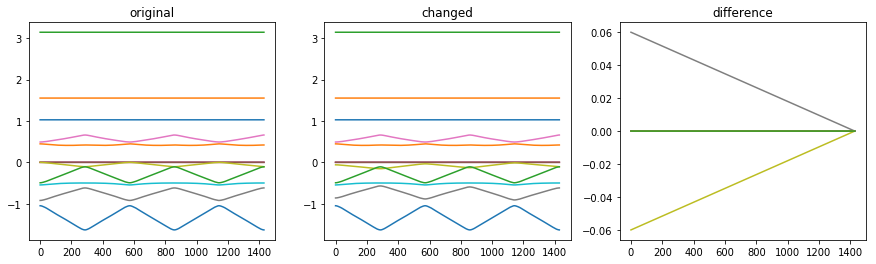

In [27]:
print_traj_ie(traj_new)
plot_compare_traj(traj_sweep, traj_new)

### Apply new change and check transition error

In [28]:
snode_approach.set_traj(update_traj_start_end(snode_approach.traj, [0]*13, DQ_i))
snode_sweep.set_traj(update_traj_start_end(snode_sweep.traj, DQ_i, DQ_e))
snode_leave.set_traj(update_traj_start_end(snode_leave.traj, DQ_e, [0]*13))

assert np.all(snode_approach.traj[-1]-snode_sweep.traj[0]<1e-6), "approach mismatch"
assert np.all(snode_sweep.traj[-1]-snode_leave.traj[0]<1e-6), "leave mismatch"

# Save updated schedule

In [ ]:
save_schedules(snode_schedule_list_table_all, snode_schedule_list_sofa_all)